In [1]:
!python -m pip install --no-index --find-links=/kaggle/input/autogluon-pkgs autogluon > /dev/null


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.9.3 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
albumentations 1.4.0 requires scikit-image>=0.21.0, but you have scikit-image 0.20.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
conda 24.3.0 requires packaging>=23.0, but you have packaging 21.3 which is incompatible.
google-cloud

In [2]:
!python -m pip install --no-index --find-links=/kaggle/input/ray-pkgs --upgrade --force-reinstall -q ray==2.6.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.8.2 requires keras-core, which is not installed.
keras-nlp 0.9.3 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
albumentations 1.4.0 requires scikit-image>=0.21.0, but you have scikit-image 0.20.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 15.0.2 which is incompatible.
autogluon-multimodal 1.0.0 requires jsonschema<4.18,>=4.14, but you have jsonschema 4.21.1 which is incompatible.
beat

# Imports

In [3]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
import joblib
import lightgbm as lgb
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from autogluon.tabular import TabularDataset, TabularPredictor


# Pipeline

In [4]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df
    
    

In [5]:
@staticmethod
def handle_dates(df):
    
     for col in df.columns:
            
            if col[-1] in ("D",):
                
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.drop("date_decision", "MONTH")
                
                return df
    
   

In [6]:
@staticmethod
def filter_cols(df):
    for col in df.columns:
        if col not in ["target", "case_id", "WEEK_NUM"]:
            isnull = df[col].is_null().mean()
            if isnull > 0.95:
                df = df.drop(col)
    for col in df.columns:
        if (col not in ["target", "case_id", "WEEK_NUM"]) and (df[col].dtype == pl.String):
            freq = df[col].n_unique()
            if (freq == 1) or (freq > 200):
                df = df.drop(col)
    return df



In [7]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        return expr_max, expr_min

    @staticmethod
    def num_expr_mean(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max
    
    @staticmethod
    def num_expr_std(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.std(col).alias(f"std_{col}") for col in cols]
        return expr_max
    
    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        return expr_max, expr_min

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        return expr_max, expr_min

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        return expr_max, expr_min
    
    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        return expr_max, expr_min

    @staticmethod
    def get_exprs(df):
        maxexprs = (Aggregator.num_expr(df)[0] +
                    Aggregator.date_expr(df)[0] +
                    Aggregator.str_expr(df)[0] +
                    Aggregator.other_expr(df)[0] +
                    Aggregator.count_expr(df)[0])
        minexprs = (Aggregator.num_expr(df)[1] +
                    Aggregator.date_expr(df)[1] +
                    Aggregator.str_expr(df)[1] +
                    Aggregator.other_expr(df)[1] +
                    Aggregator.count_expr(df)[1])
        return maxexprs, minexprs

def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1, 2]:
        maxexprs, minexprs = Aggregator.get_exprs(df)
        df = df.group_by("case_id").agg(*maxexprs, *minexprs)
    return df



In [8]:
def read_files(regex_path, depth=None):
    chunks = [pl.read_parquet(path).pipe(Pipeline.set_table_dtypes) for path in glob(str(regex_path))]
    df = pl.concat(chunks, how="vertical_relaxed")
    if depth in [1, 2]:
        maxexprs, minexprs = Aggregator.get_exprs(df)
        df = df.group_by("case_id").agg(*maxexprs, *minexprs)
    return df



In [9]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (df_base.with_columns(
        month_decision=pl.col("date_decision").dt.month(),
        weekday_decision=pl.col("date_decision").dt.weekday(),
    ))
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base



In [10]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols



In [11]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type) == "category":
            continue
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df



# Configuration

In [12]:
sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
DRY_RUN = sample.shape[0] == 10  # if num of records of test data is 10, dry-run is enabled
PRESETS = "medium_quality"
MODEL_PATH = "/kaggle/input/home-credit-automl-training/predictor"
ROOT = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR = ROOT / "parquet_files" / "train"
TEST_DIR = ROOT / "parquet_files" / "test"

data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet")
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1)
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2)
    ]
}



In [13]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df
    
    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns((pl.col(col) - pl.col("date_decision")).dt.days().alias(col))
        df = df.drop("date_decision").drop("MONTH")
        return df
    
    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.95:
                    df = df.drop(col)
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        return df


In [14]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)


/tmp/ipykernel_18/1098963660.py:21: DeprecationWarning: `days` is deprecated. It has been renamed to `total_days`.
  df = df.with_columns((pl.col(col) - pl.col("date_decision")).dt.days().alias(col))


train data shape:	 (1526659, 528)


In [15]:
df_train = df_train.pipe(Pipeline.filter_cols)
print("train data shape:\t", df_train.shape)


train data shape:	 (1526659, 341)


In [16]:
df_train, cat_cols = to_pandas(df_train)
print(df_train.shape)
df_train.head()


(1526659, 341)


,case_id,WEEK_NUM,target,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,...,max_amount_416A,max_openingdate_313D,max_num_group1_9,min_amount_416A,min_openingdate_313D,min_num_group1_9,max_openingdate_857D,max_num_group1_10,min_openingdate_857D,min_num_group1_10
0,0,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
del data_store
df_train = reduce_mem_usage(df_train)
gc.collect()

Memory usage of dataframe is 3107.00 MB
Memory usage after optimization is: 1055.59 MB
Decreased by 66.0%


68

In [18]:
# Training
NUM = len(df_train)

if DRY_RUN:
    print(f"df_train.shape : {df_train.shape} --> ", end="")
    df_train = df_train.iloc[:NUM]
    print(df_train.shape)


df_train.shape : (1526659, 341) --> (1526659, 341)


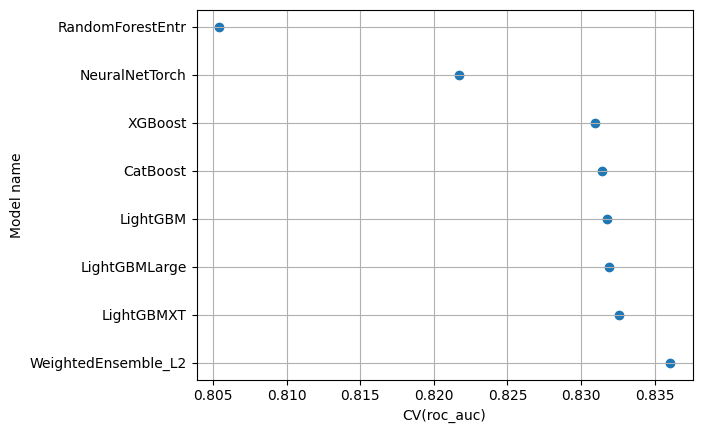

In [19]:
# Load model
predictor = TabularPredictor.load(path=MODEL_PATH)
predictor.leaderboard()
df_lb = predictor.leaderboard()

plt.scatter(df_lb["score_val"], df_lb["model"])
plt.grid()
plt.xlabel("CV(roc_auc)")
plt.ylabel("Model name")
plt.show()

In [20]:
# Test Files Read & Feature Engineering
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet")
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1)
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2)
    ]
}



In [21]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)


test data shape:	 (10, 527)


/tmp/ipykernel_18/1098963660.py:21: DeprecationWarning: `days` is deprecated. It has been renamed to `total_days`.
  df = df.with_columns((pl.col(col) - pl.col("date_decision")).dt.days().alias(col))


In [22]:
df_test = df_test.select([col for col in df_test.columns if col != "target"])
print("test data shape:\t", df_test.shape)


test data shape:	 (10, 527)


In [23]:
df_test, cat_cols = to_pandas(df_test, cat_cols)  # cat_cols was created by train data
print(df_test.shape)
df_test.head()


(10, 527)


,case_id,WEEK_NUM,month_decision,weekday_decision,assignmentdate_238D,assignmentdate_4527235D,assignmentdate_4955616D,birthdate_574D,contractssum_5085716L,dateofbirth_337D,...,max_pmts_dpdvalue_108P,max_pmts_pmtsoverdue_635A,max_pmts_date_1107D,max_num_group1_11,max_num_group2,min_pmts_dpdvalue_108P,min_pmts_pmtsoverdue_635A,min_pmts_date_1107D,min_num_group1_11,min_num_group2
0,57543,100,5,5,NaN,NaN,NaN,NaN,151364.00,-14804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,57549,100,1,1,NaN,NaN,-1352.0,NaN,1563077.92,-22723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57551,100,11,5,NaN,NaN,NaN,NaN,2926195.30,-14090,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57552,100,11,5,NaN,NaN,-740.0,NaN,747031.73,-23768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57569,100,12,1,NaN,NaN,-3720.0,NaN,NaN,-26408,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
del data_store
df_test = reduce_mem_usage(df_test)
gc.collect()

Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.03 MB
Decreased by 23.5%


3538

In [25]:
# Prediction
X_test = df_test.drop(columns=["case_id", "WEEK_NUM"])
test_data = TabularDataset(df_test)
y_pred = predictor.predict_proba(test_data).iloc[:, 1].values



In [26]:
# Submission
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")
df_subm["score"] = y_pred
print("Check null: ", df_subm["score"].isnull().any())
df_subm.head()
df_subm.to_csv("submission.csv")

Check null:  False
